# Statement

In this work, I classified fils reviews between negative and positive, using spaCy and nltk libraries. The data was preprocessed before entering to the model training by lemmmatization on corpus. Finaly I compared the models I got and checked them on new sentences wroted by me.

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. We will be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

# Init

In [4]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import spacy

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [6]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Loading and Viewing Data

In [7]:
def get_precent_of_na_df(df,num):
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    df_nulls['Percent of Nulls %'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    df_nulls = df_nulls.sort_values("Percent of Nulls %",ascending=False)
    return df_nulls

def explore(df):
    df = df
    print(df.head())
    print("Number of duplicated rows",df.duplicated().sum())
    print("Data shape",df.shape)
    print('Columns with nulls:')
    display(get_precent_of_na_df(df,4))
    display(df.info())
    display(df.describe())
    print("Number of duplicated rows")
    display(df.duplicated().sum())
    temp_raw_data=df.copy()
    fig = plt.figure(figsize = (7,10))
    ax = fig.gca()
    temp_raw_data.hist(ax = ax)
    fig = ax.get_figure()

In [8]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage impl

,Missing Values,Percent of Nulls %
tconst,0,0.0
average_rating,2,0.0
ds_part,0,0.0
pos,0,0.0
sp,0,0.0
rating,0,0.0
review,0,0.0
votes,2,0.0
genres,0,0.0
title_type,0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


None

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


Number of duplicated rows


0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


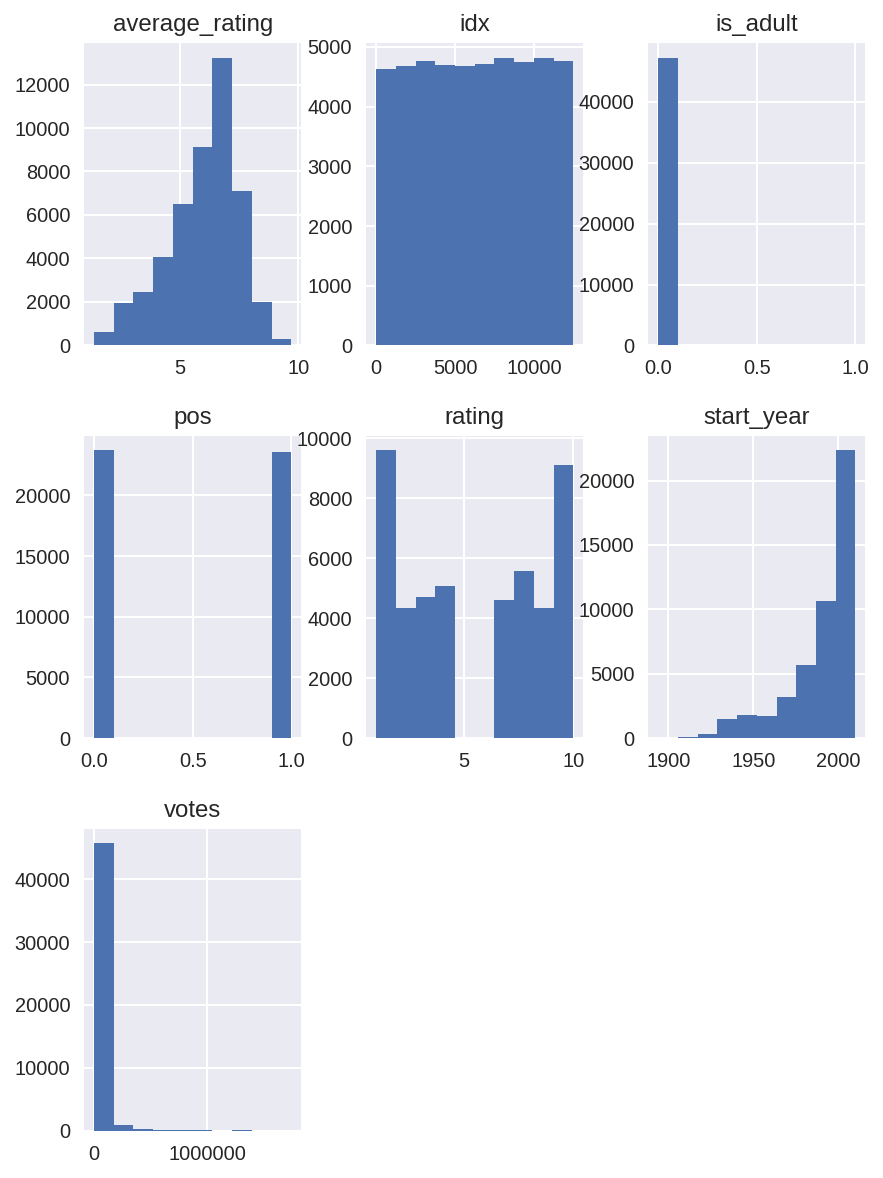

In [9]:
explore(df_reviews)

In [10]:
# we have two rows with nulls, just fill them so model would not get stucked
df_reviews['average_rating'] = df_reviews['average_rating'].fillna(6.0)
df_reviews['votes'] = df_reviews['votes'].fillna(df_reviews['votes'].min())

# EDA

In [11]:
# checking if target column is equilibrate
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Let's check the number of movies and reviews over years.

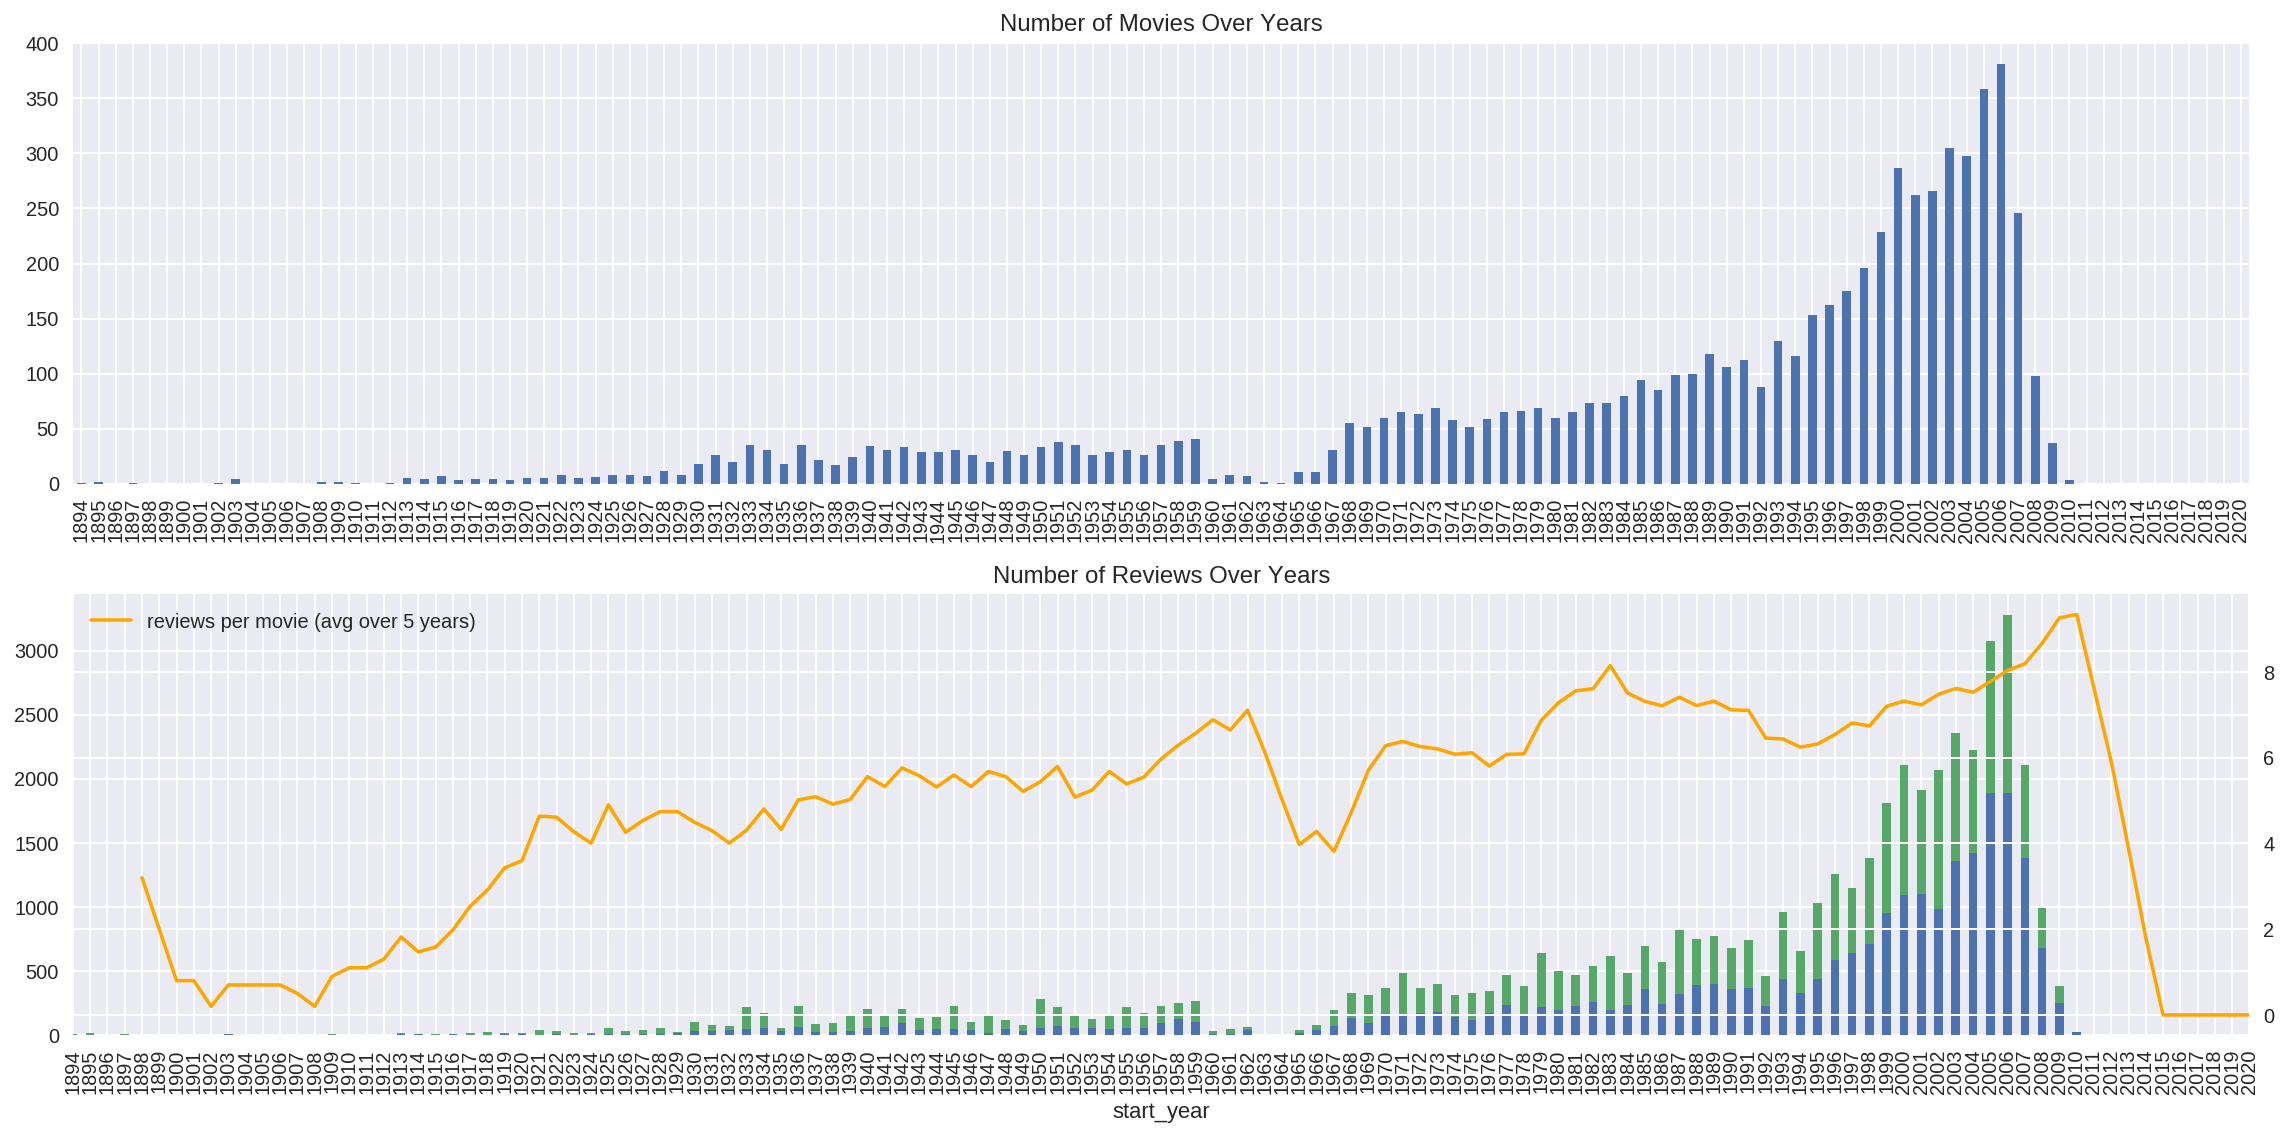

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

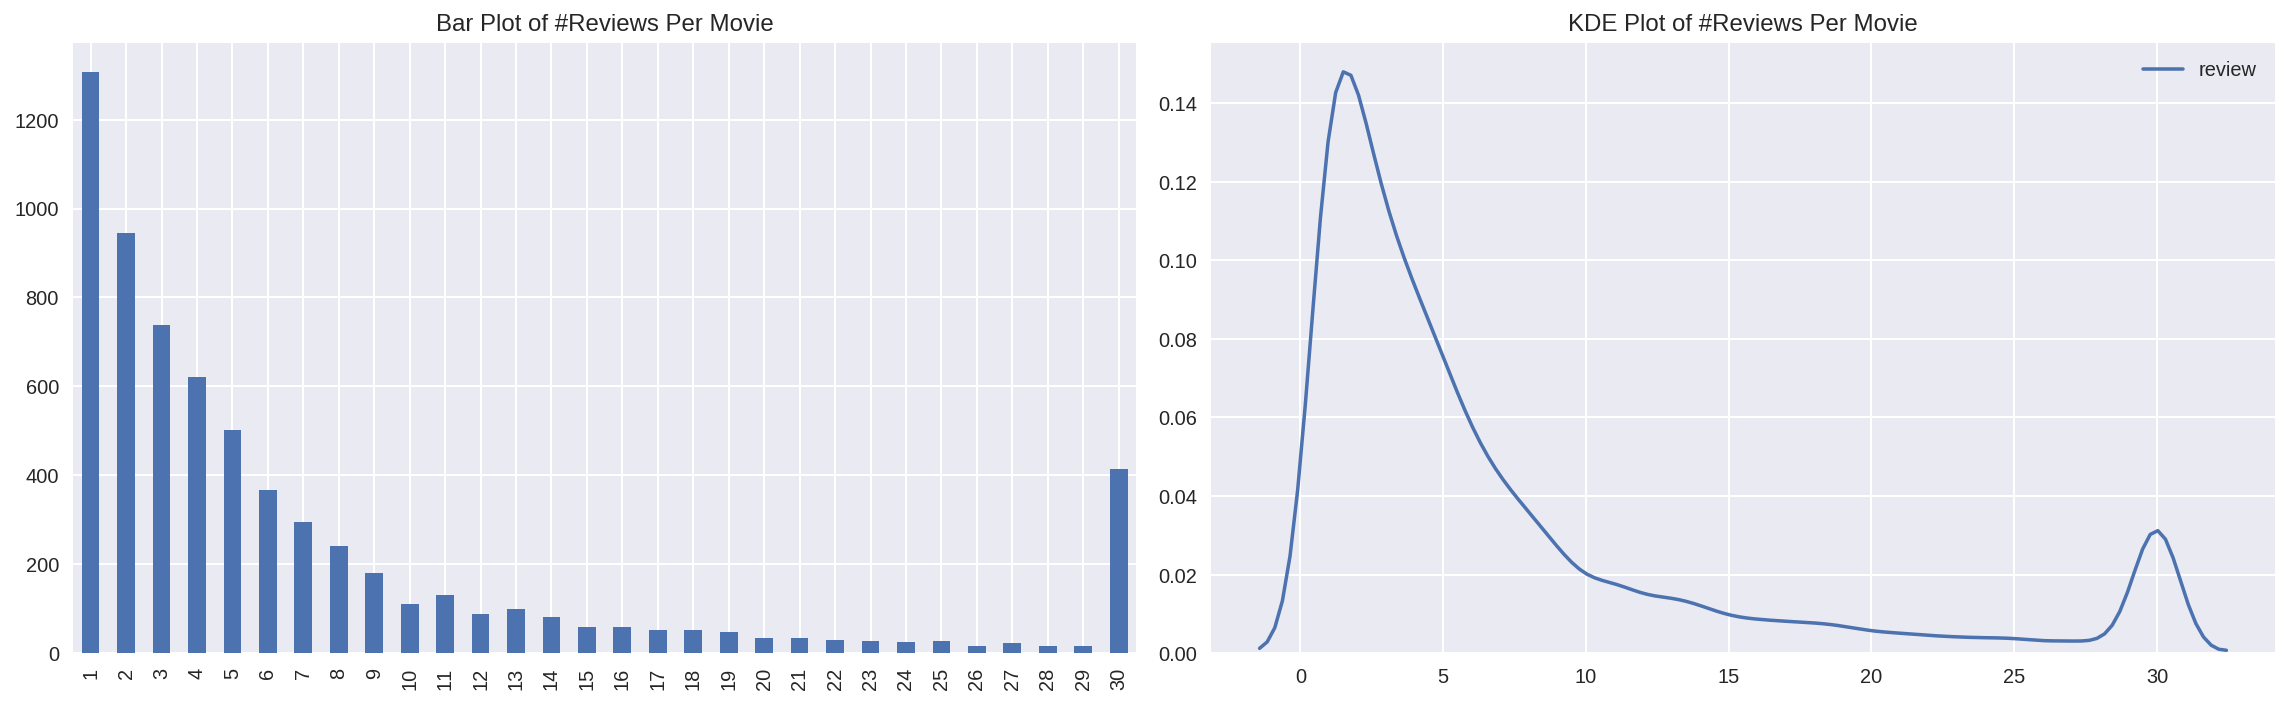

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

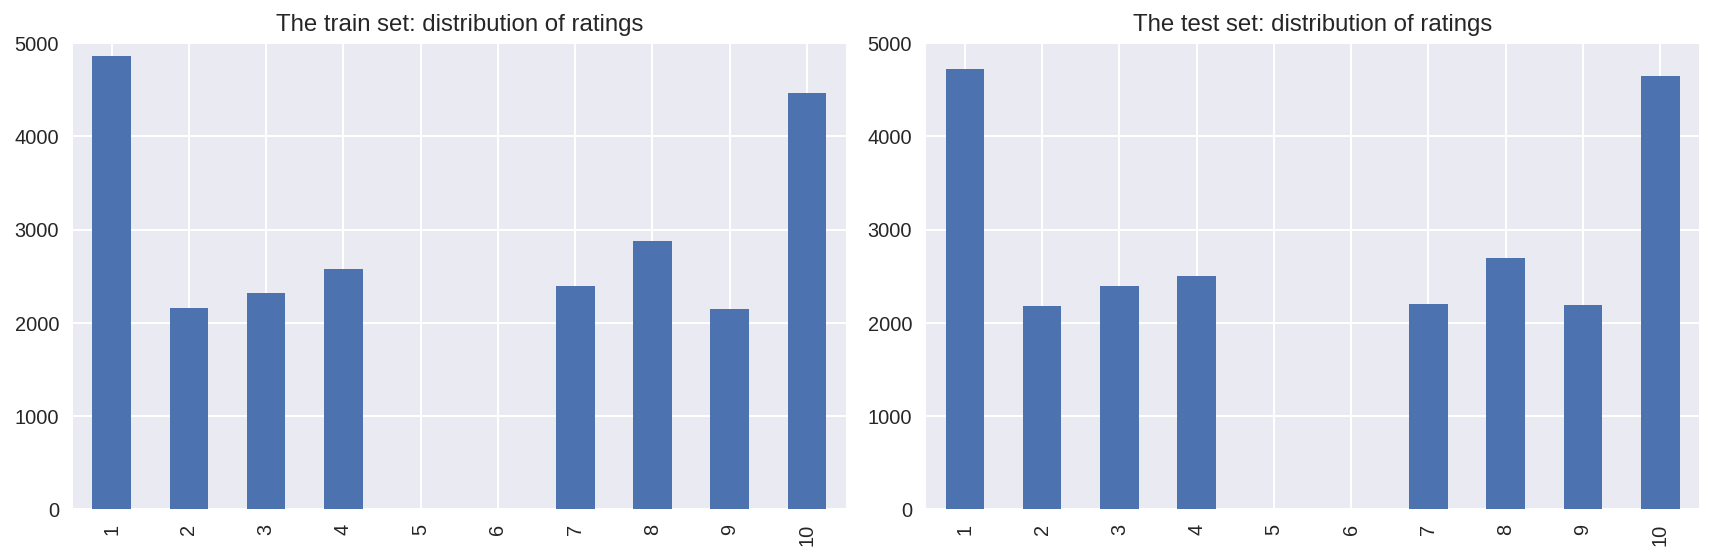

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

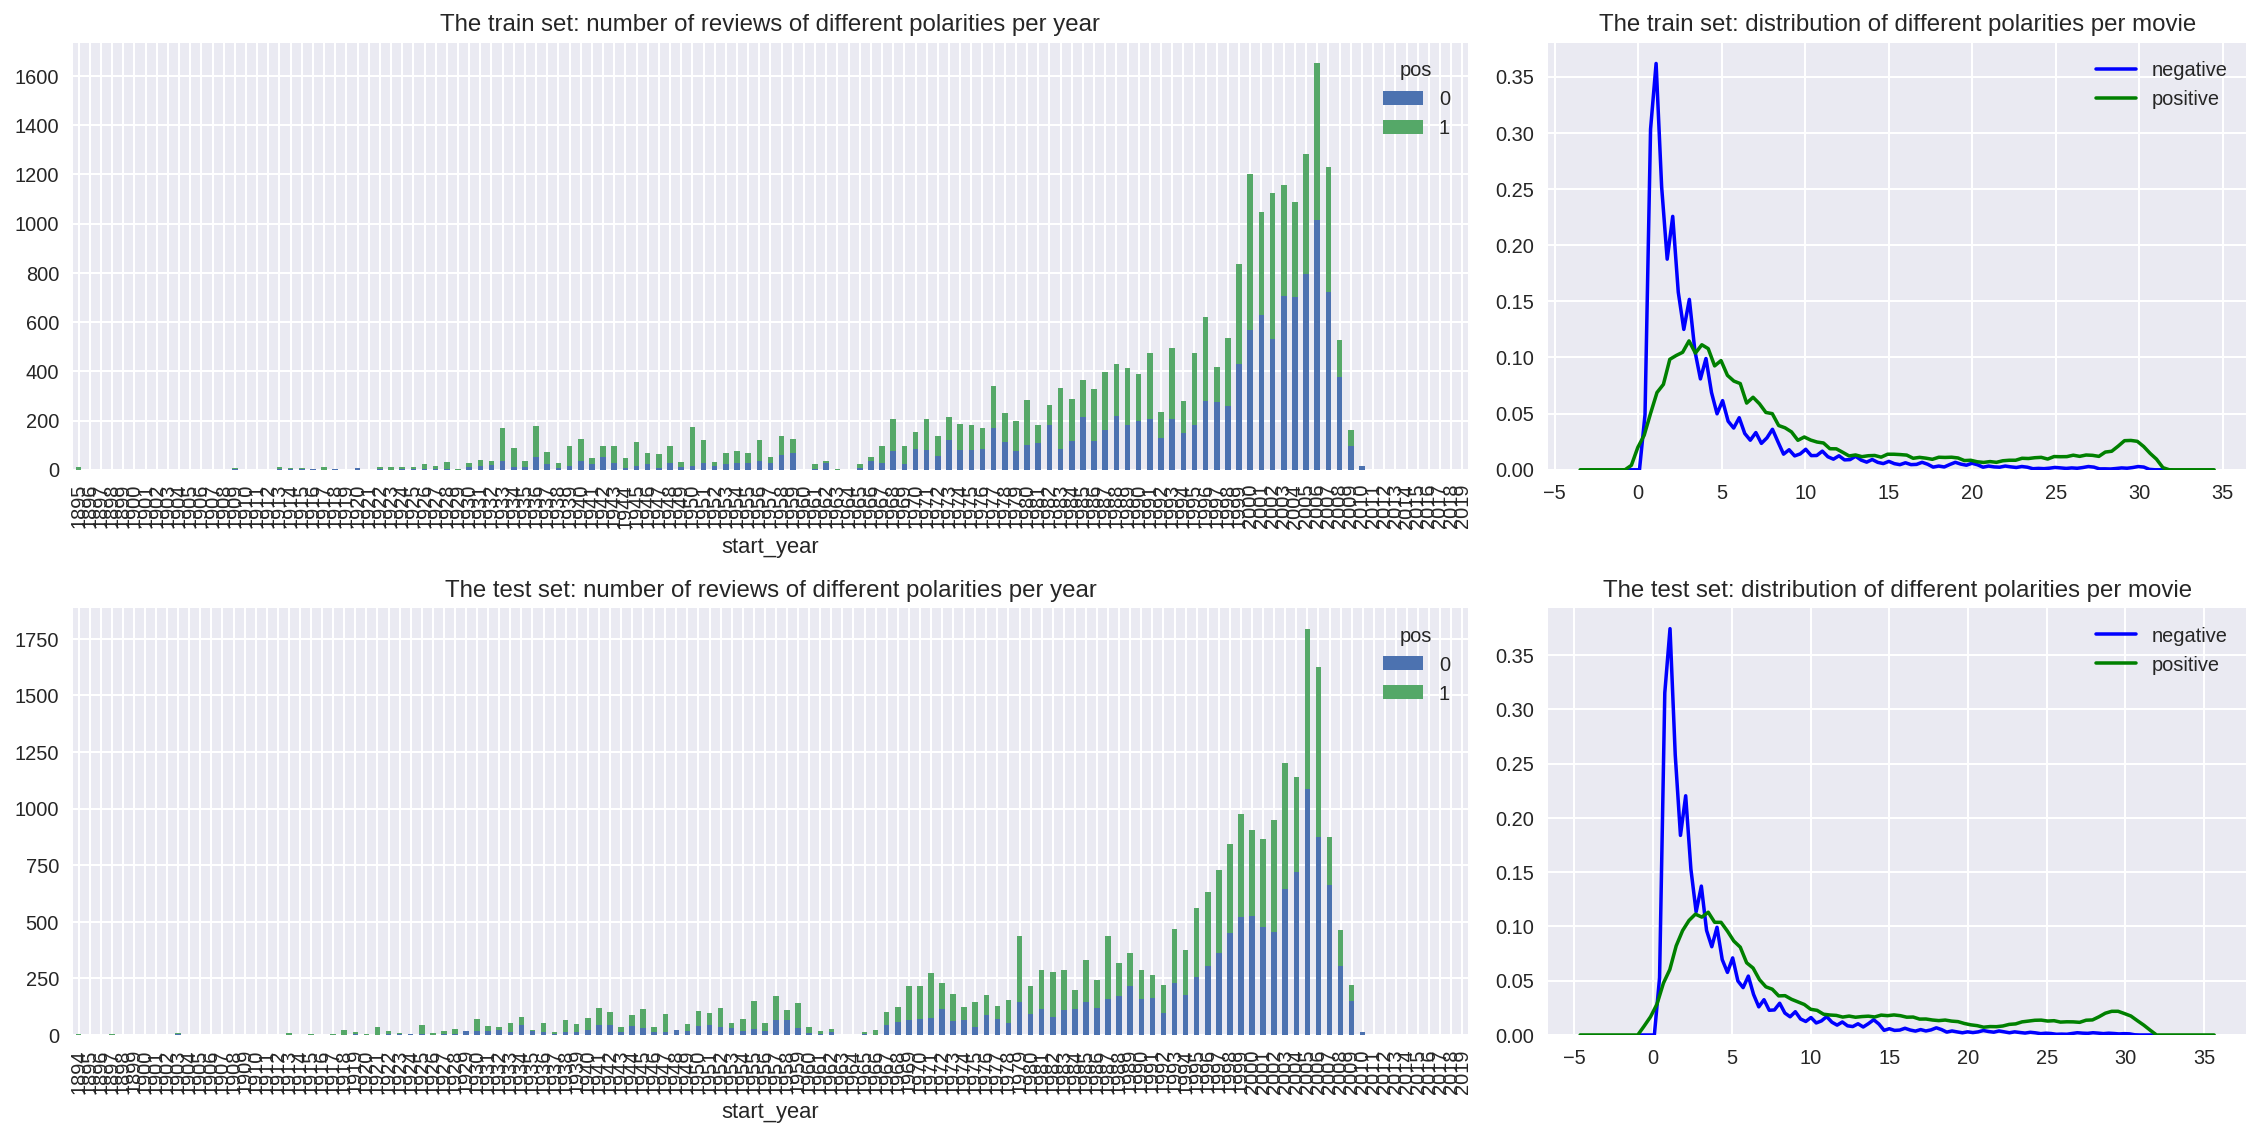

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

# Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

# Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [14]:
def clear_and_lower_text(row):
    text = row['review']
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.split()
    text = " ".join(text)    
    return text

df_reviews['review_norm'] = df_reviews.apply(clear_and_lower_text, axis=1)

# Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


# Model 1 - NLTK, TF-IDF and LR

### TF-IDF

In [19]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer  = WordNetLemmatizer()

In [20]:
def text_preprocessing_1(row):
    text = row['review_norm']
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

df_reviews_train['review_lemm_1'] = df_reviews_train.apply(text_preprocessing_1, axis=1)
df_reviews_test['review_lemm_1'] = df_reviews_test.apply(text_preprocessing_1, axis=1)

In [21]:
stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
corpus_train = df_reviews_train['review_lemm_1']
corpus_test = df_reviews_test['review_lemm_1']

# creating a TF-IDF matrix without stop words
train_features_1 = count_tf_idf.fit_transform(corpus_train)
test_features_1 = count_tf_idf.transform(corpus_test)

In [22]:
%%time
model_1 = LogisticRegression()
model_1.fit(train_features_1,train_target)
score = model_1.score(train_features_1, train_target)
print('Train Score ', score)
test_target = model_1.predict(test_features_1)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Score  0.9357455034459573
CPU times: user 4.42 s, sys: 3.5 s, total: 7.92 s
Wall time: 7.93 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.94   1.0
F1         0.94   1.0
APS        0.98   1.0
ROC AUC    0.98   1.0


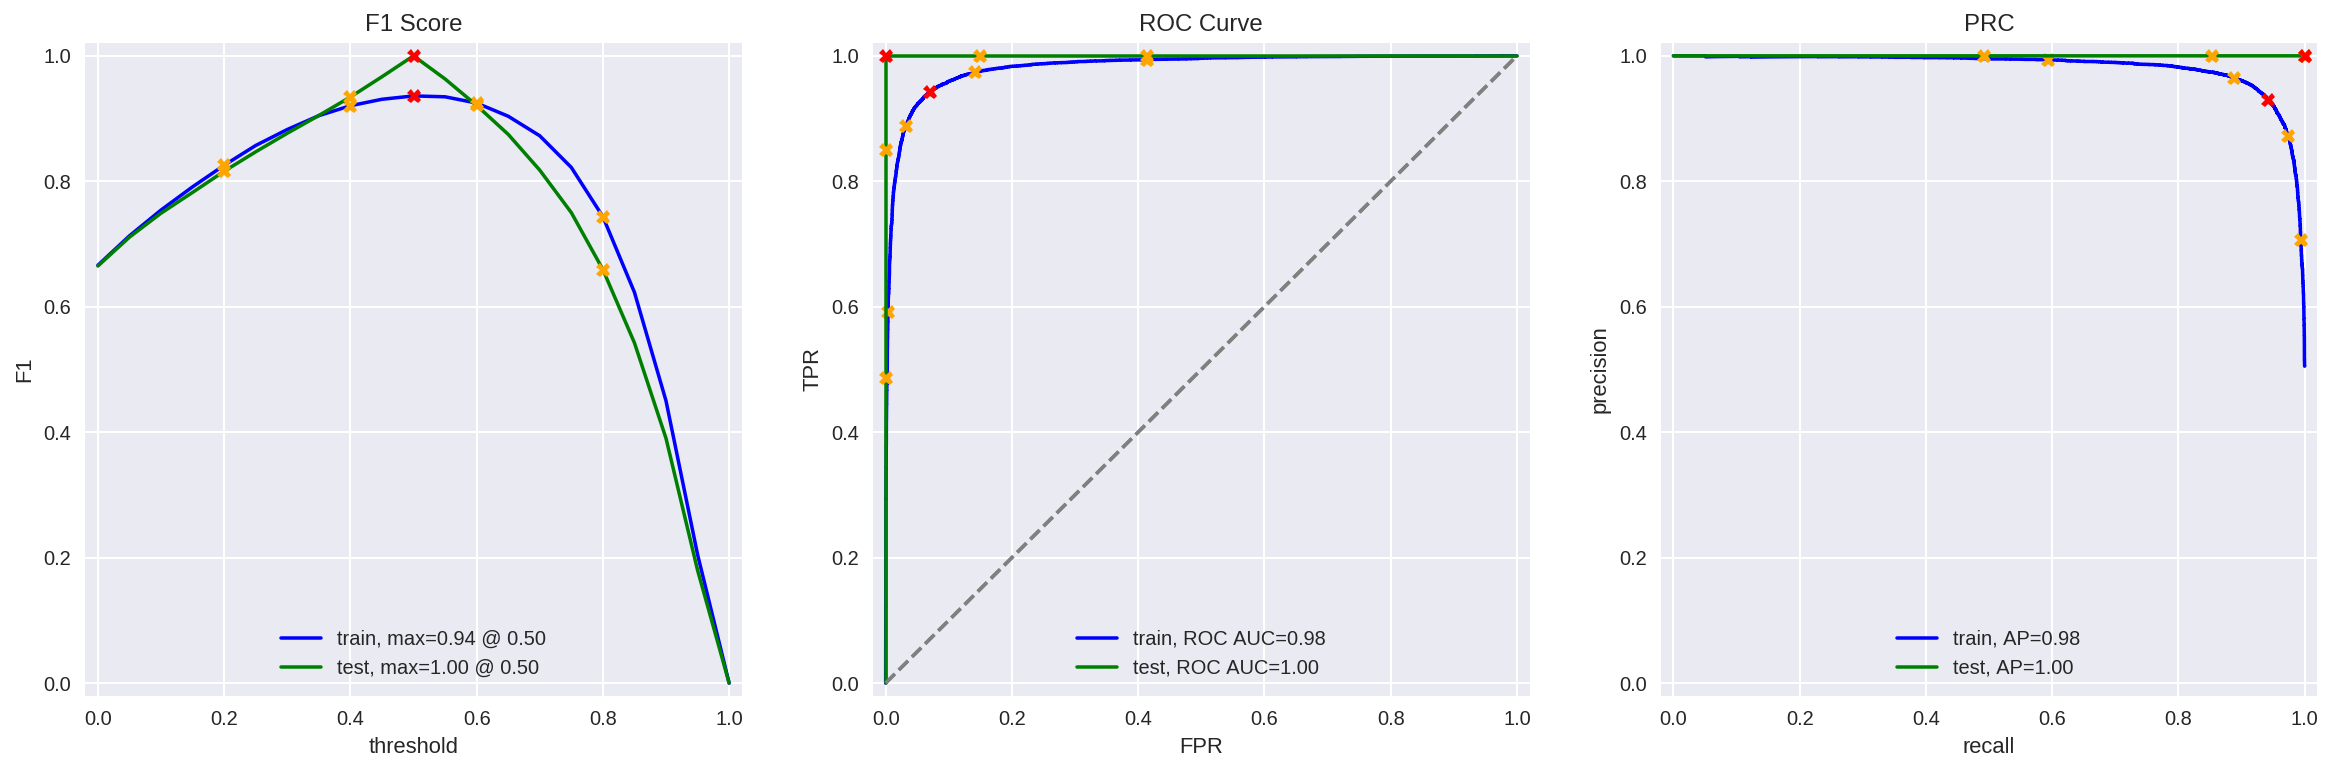

In [23]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

# Model 0 - Constant

In [25]:
train_features_0 = df_reviews_train.drop(columns=['pos','review_lemm_1'], axis=1)
test_features_0 = df_reviews_test.drop(columns=['pos','review_lemm_1'], axis=1)

In [26]:
from sklearn.dummy import DummyClassifier

In [27]:
%%time
model_0 = DummyClassifier()
model_0.fit(train_features_0,train_target)
score = model_0.score(train_features_0, train_target)
print('Train Score ', score)
test_target = model_0.predict(test_features_0)

Train Score  0.499075474869726
CPU times: user 4.68 ms, sys: 4.04 ms, total: 8.71 ms
Wall time: 7.54 ms


          train  test
Accuracy   0.49  0.51
F1         0.49  0.50
APS        0.50  0.50
ROC AUC    0.50  0.50


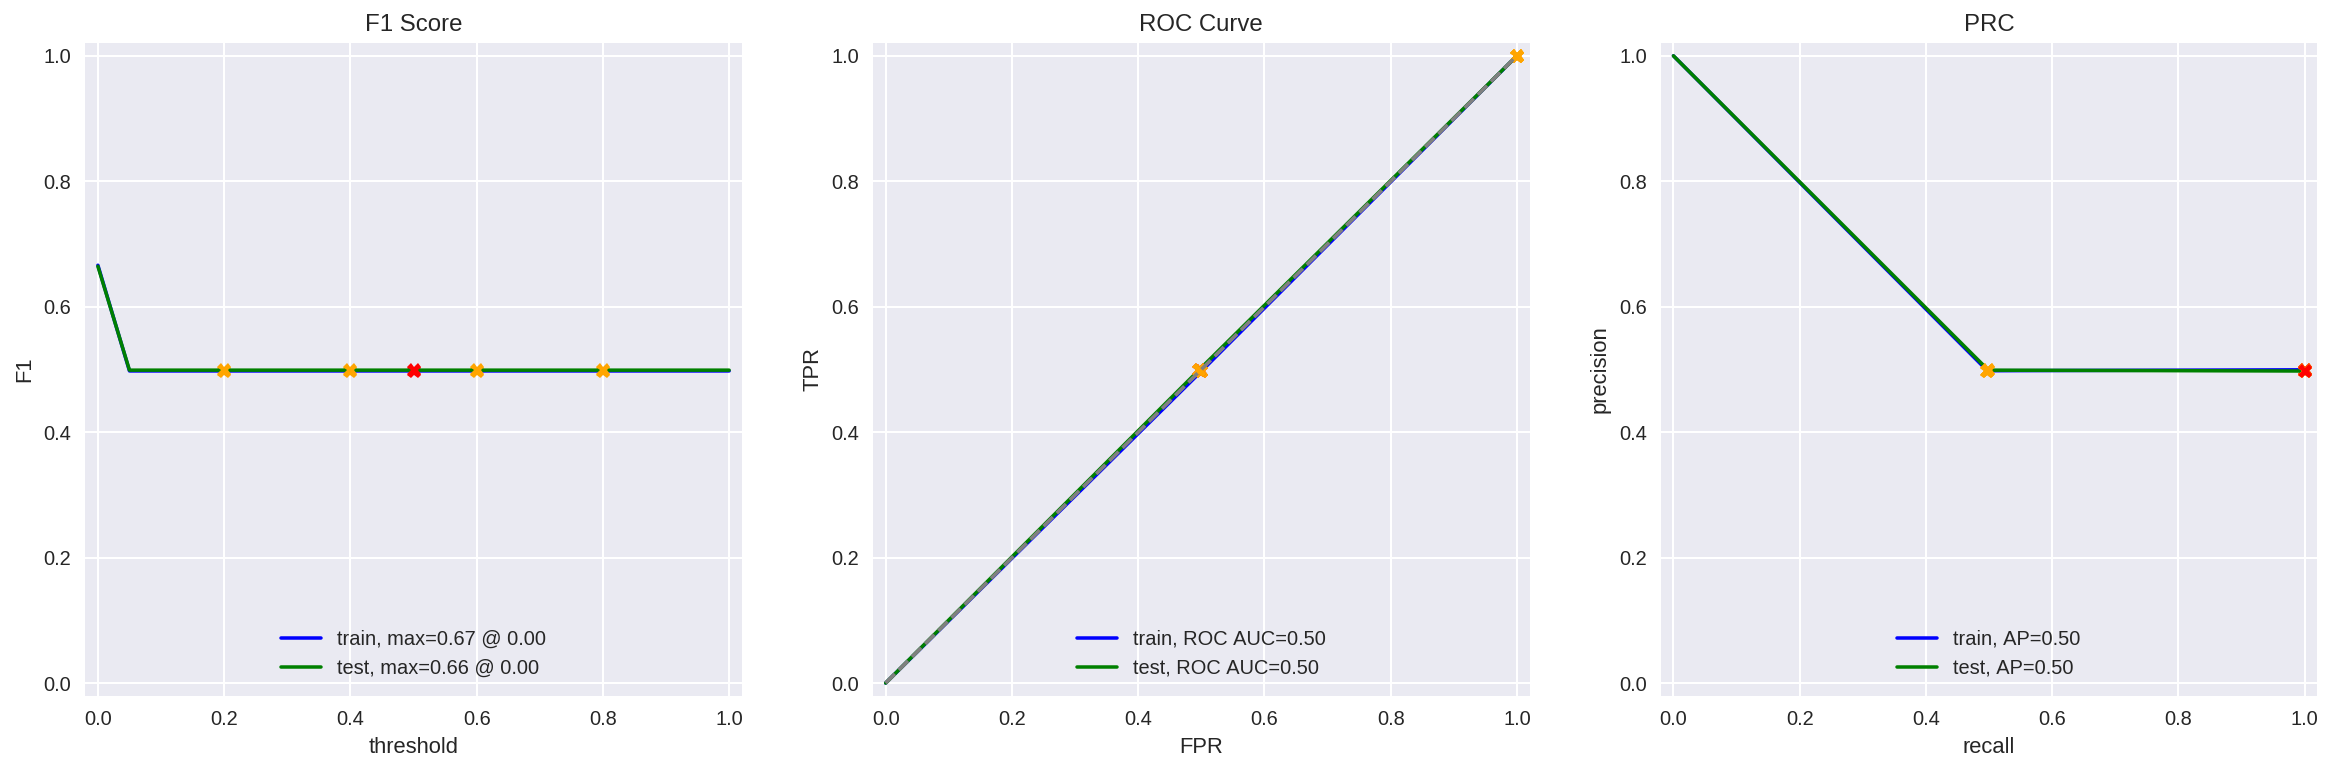

In [28]:
evaluate_model(model_0, train_features_0, train_target, test_features_0, test_target)

# Model 3 - spaCy, TF-IDF and LR

In [29]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [30]:
def text_preprocessing_3(row):
    text = row['review_norm']
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
#     tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

df_reviews_train['review_lemm_3'] = df_reviews_train.apply(text_preprocessing_3, axis=1)
df_reviews_test['review_lemm_3'] = df_reviews_test.apply(text_preprocessing_3, axis=1)

In [31]:
count_tf_idf = TfidfVectorizer()
corpus_train = df_reviews_train['review_lemm_3']
corpus_test = df_reviews_test['review_lemm_3']

# creating a TF-IDF matrix without stop words
train_features_3 = count_tf_idf.fit_transform(corpus_train)
test_features_3 = count_tf_idf.transform(corpus_test)

In [32]:
%%time
model_3 = LogisticRegression()
model_3.fit(train_features_3,train_target)
score = model_3.score(train_features_3, train_target)
print('Train Score ', score)
test_target = model_3.predict(test_features_3)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Score  0.9311228777945874
CPU times: user 4.34 s, sys: 3.52 s, total: 7.86 s
Wall time: 7.87 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.93   1.0
F1         0.93   1.0
APS        0.98   1.0
ROC AUC    0.98   1.0


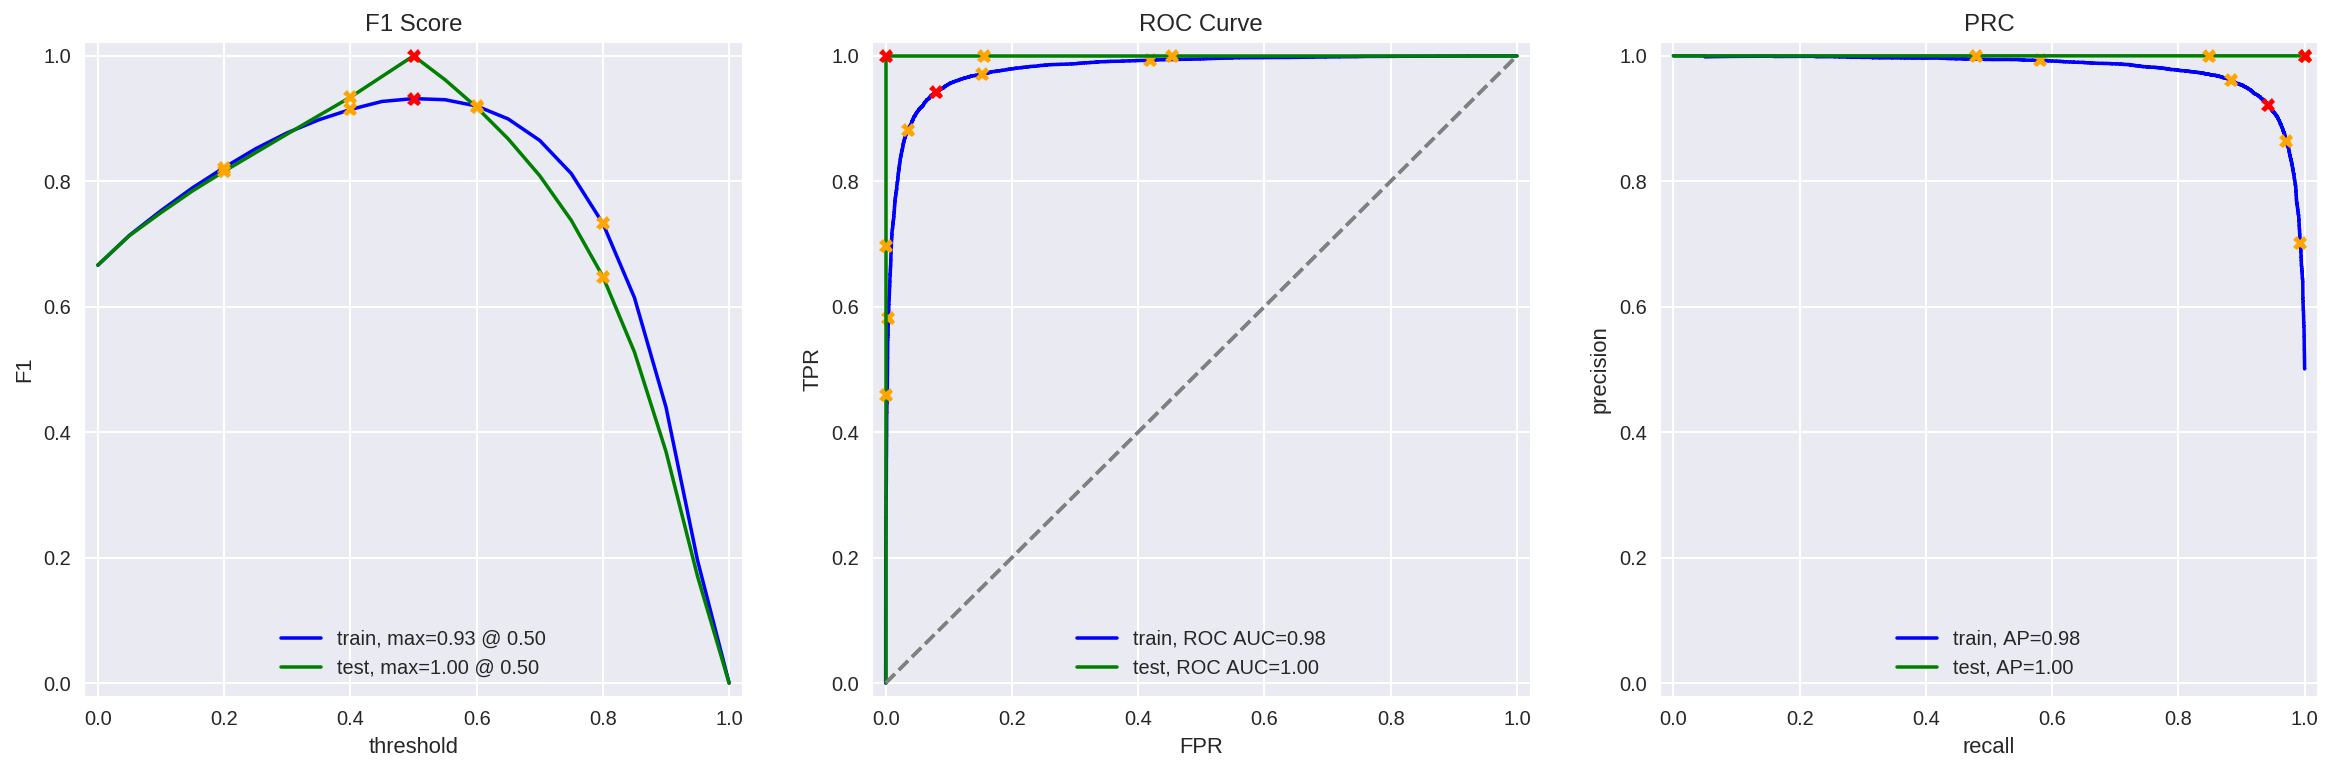

In [33]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

# Model 4 - spaCy, TF-IDF and LGBMClassifier

In [34]:
from lightgbm import LGBMClassifier

In [35]:
count_tf_idf = TfidfVectorizer()
corpus_train = df_reviews_train['review_lemm_3']
corpus_test = df_reviews_test['review_lemm_3']

# creating a TF-IDF matrix without stop words
train_features_4 = count_tf_idf.fit_transform(corpus_train)
test_features_4 = count_tf_idf.transform(corpus_test)

In [36]:
%%time
model_4 = LGBMClassifier()
model_4.fit(train_features_4,train_target)
score = model_4.score(train_features_4, train_target)
print('Train Score ', score)
test_target = model_4.predict(test_features_4)

Train Score  0.9090183224071272
CPU times: user 2min 13s, sys: 781 ms, total: 2min 14s
Wall time: 2min 15s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.91   1.0
F1         0.91   1.0
APS        0.97   1.0
ROC AUC    0.97   1.0


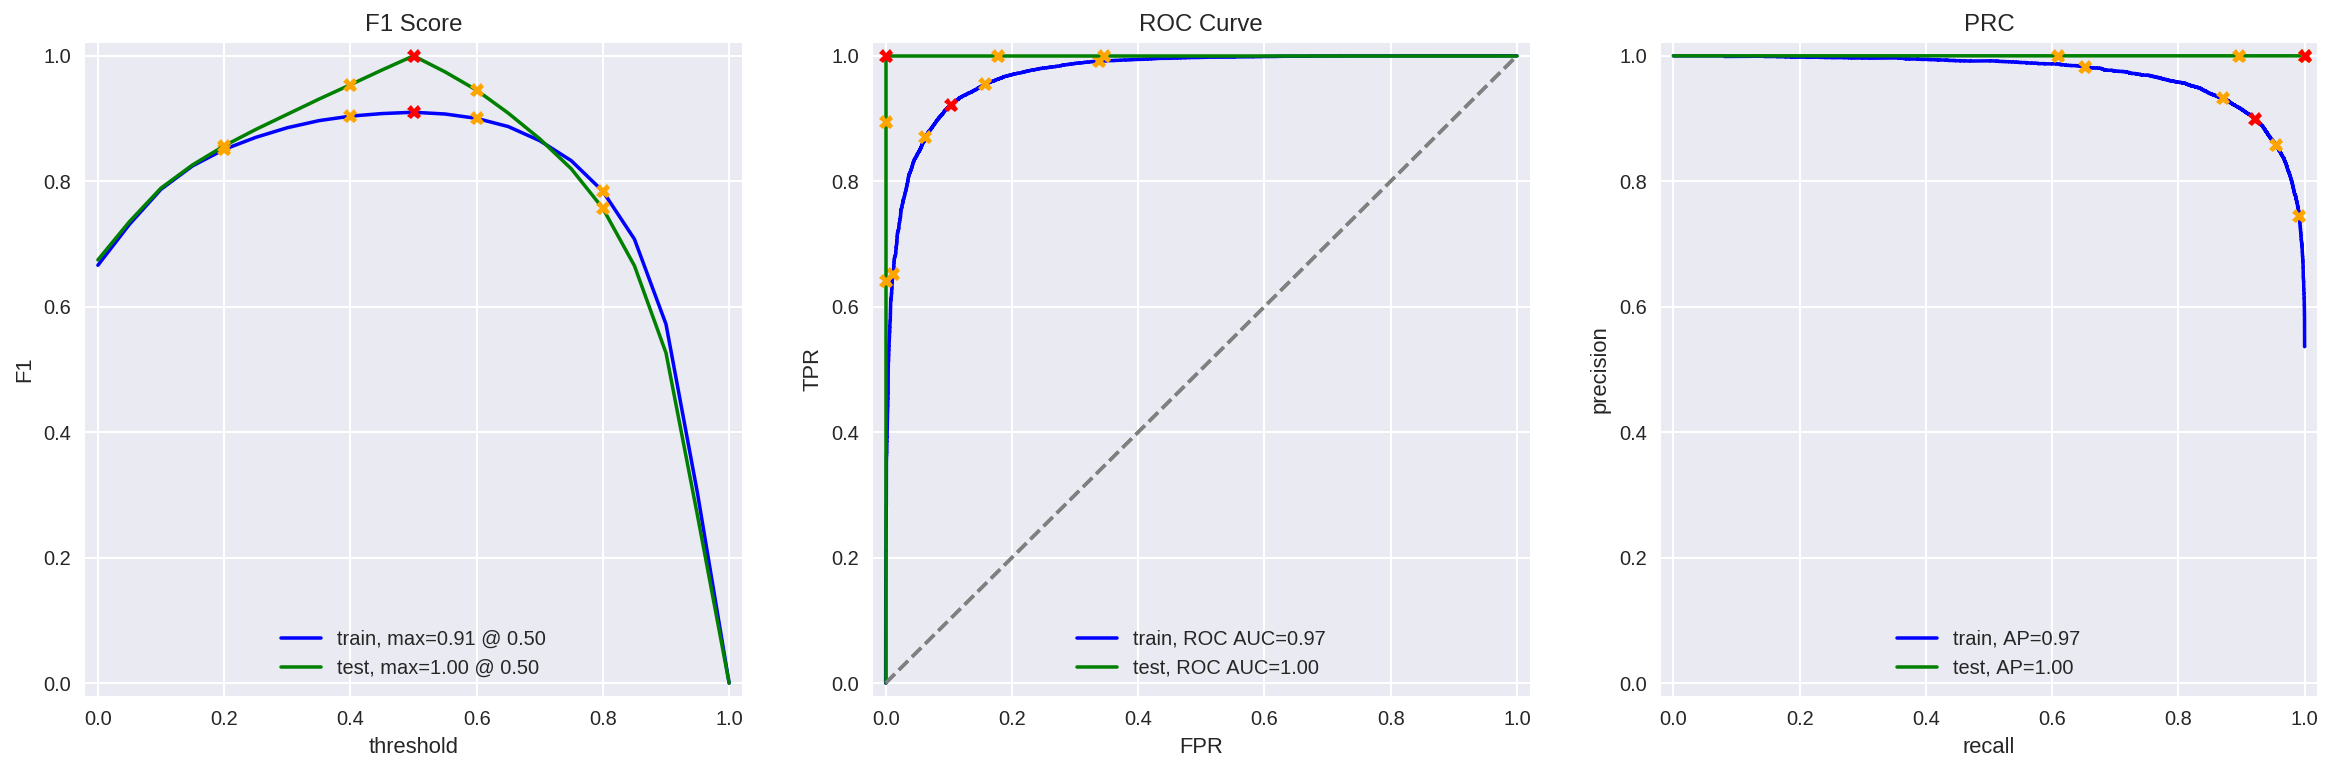

In [37]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

#  Model 5 - BERT

In [38]:
import torch
import transformers
from sklearn.model_selection import train_test_split

In [39]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')
sample_size = 400

In [40]:
df_reviews_bert = df_reviews.copy().sample(sample_size).reset_index(drop=True)

In [41]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100):
    
    ids_list = []
    attention_mask_list = []

    max_length = 512

    for input_text in texts.iloc[:sample_size]:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    batch_size = 100

    embeddings = []

    for i in tqdm(range(len(ids_list) // batch_size)):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(ids_batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].numpy())
        
    return np.concatenate(embeddings)

In [2]:
features_5 = BERT_text_to_embeddings(df_reviews_bert['review_norm'])
target_5 = df_reviews.iloc[:sample_size]['pos']

train_features_5,test_features_5,train_target,test_target = train_test_split(features_5,target_5, test_size=0.5, random_state=12345)

NameError: name 'BERT_text_to_embeddings' is not defined

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
model_5 = LogisticRegression()
model_5.fit(train_features_5,train_target)
score = model_5.score(train_features_5, train_target)
print('Train Score ', score)
test_target = model_5.predict(test_features_5)

In [ ]:
evaluate_model(model_5, train_features_5, train_target, test_features_5, test_target)

# Evaluating Firts Results

1. The best result had the first model: NLTK, TF-IDF and LR. The results where: Accuracy = 0.94, F1 = 0.94, APS = 0.98, ROC AUC = 0.98. The model run fast, but the lemmatization took time.
2. Also the third model: spaCy, TF-IDF and LR had very good results, with F1 = 0.92.
3. Both LR models had very good results.
4. The model: spaCy, TF-IDF and LGBMClassifier had same result as the LR model for spaCy, but the time to train the model was much longer and does not worth it.
5. The BERT model could not run somehow.
6. The model based on DummyClassifier had very bad results, making it better to choose random.

# My Reviews

In [12]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews.apply(clear_and_lower_text, axis=1)
my_reviews

NameError: name 'clear_and_lower_text' is not defined

In [ ]:
my_reviews

## Model 1

In [15]:
my_reviews['review_lemm_1'] = my_reviews.apply(text_preprocessing_1, axis=1)
count_tf_idf = TfidfVectorizer()
my_reviews_corpus_train = df_reviews_train['review_lemm_1']
my_reviews_corpus_test = my_reviews['review_lemm_1']

# creating a TF-IDF matrix without stop words
my_reviews_train_features_1 = count_tf_idf.fit_transform(my_reviews_corpus_train)
my_reviews_test_features_1 = count_tf_idf.transform(my_reviews_corpus_test)

NameError: name 'text_preprocessing_1' is not defined

In [ ]:
test_features_1.size

In [ ]:
texts = my_reviews['review_lemm_1']

my_reviews_pred_prob = model_1.predict_proba(test_features_1)

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i][0]:.2f}:  {review}')

## Model 3

In [ ]:
my_reviews['review_lemm_3'] = my_reviews.apply(text_preprocessing_3, axis=1)
count_tf_idf = TfidfVectorizer()
my_reviews_corpus_train = df_reviews_train['review_lemm_3']
my_reviews_corpus_test = my_reviews['review_lemm_3']

# creating a TF-IDF matrix without stop words
my_reviews_train_features_3 = count_tf_idf.fit_transform(my_reviews_corpus_train)
my_reviews_features_3 = count_tf_idf.transform(my_reviews_corpus_test)

In [ ]:
texts = my_reviews['review_lemm_3']

my_reviews_pred_prob = model_3.predict_proba(my_reviews_features_3)

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i][0]:.2f}:  {review}')

## Model 4

In [ ]:
texts = my_reviews['review_lemm_3']

my_reviews_pred_prob = model_4.predict_proba(my_reviews_test_features_3)

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i][0]:.2f}:  {review}')

## Model 5

In [1]:
texts = my_reviews['review_norm']

my_reviews_features_5 = BERT_text_to_embeddings(texts)

my_reviews_pred_prob = model_3.predict_proba(my_reviews_features_5)

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i][0]:.2f}:  {review}')

NameError: name 'my_reviews' is not defined

# Conclusions

Trying to classify sentences is more complicated than just numbers. We could see that the LR models ran fast and where very efficient. On this case, the difference between NLTK and spaCy was not significant, but only the the comparition between LR and LGBMClassifier was significant on the time it took to train the model.

Since both lemmatization style took long time on lemmatize all sentence, the lemmatization should be done once and keep it safe. The results were very good for F1 parameter.

# Check List

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions

In [ ]:
# drafts

In [ ]:
my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

In [ ]:
# draft
df_copy = df_reviews.copy()
df_copy = df_copy.head()
df_copy['review_lemm'] = df_copy.apply(lemmatize, axis=1)
print(df_copy)

In [ ]:
count_vect = CountVectorizer(ngram_range=(2, 2))
n_gramm_train = count_vect.fit_transform(corpus_train)
n_gramm_test = count_vect.fit_transform(corpus_test)